# Transformer 실습

- 과제 목표: IMDB 리뷰에서 마지막 토큰 예측

- 마지막 토큰을 예측하는 것이므로 데이터셋에서 라벨에 관한 정보는 필요가 없습니다.
    1) 물론 정확히는 max_len 기준 바로 앞 토큰을 예측하는 것이기 때문에, 첫 번째 토큰을 가지고 399번째 토큰을 맞추는 문제가 됩니다.

- 그러나 데이터셋을 살펴본다는 취지에서 일단 datasetdict까지는 라벨을 build에 사용하는 것으로 합니다.

- 추후 collate_fn에서 제외할 예정입니다.

## [MY CODE] About Dataset, Tokenizer

### Dataset

- 데이터셋 설명: https://huggingface.co/datasets/stanfordnlp/imdb

- 25000 train sample, 25000개의 test sample은 긍부정에 관한 영화리뷰 이진분류 입니다. neg (0), pos (1).

- 50000개의 sample은 라벨이 없는 영화리뷰 데이터입니다. 

- 비지도 학습용 데이터는 배제하고 모델링하겠습니다.

### About Tokenizer

- BertTokenizer는 input_ids, attention_mask, input type 등을 인코딩하는 과정에서 사용된다.

- 여담으로 모든 언어 모델은 토크나이저가 없으면 무용지물이다. 해당 토큰화 기법에 맞춰서 학습이 되기 때문이다.

### Sample Check

- text를 확인해보았을 때 분량이 상당히 길다는 것을 알 수 있다. 

In [1]:
# 아래에서 사용할 모든 변수들입니다.
# 원래라면 config 파일로 모아두어야 하지만 현재 과제에선 생략하겠습니다.
import torch

test_size = 0.5
random_state = 42
max_len = 400
batch_size=64
d_model=32
n_layers=2
dff = 32
n_epochs = 50
device = "cuda" if torch.cuda.is_available else "cpu"

In [2]:
from datasets import load_dataset
from transformers import AutoTokenizer
import torch
from sklearn.model_selection import train_test_split 

ds = load_dataset('stanfordnlp/imdb')
# 아래는 토크나이저를 받아오는 좀 더 일반적인 방법으로 구성하였습니다. 
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
vocab_size = len(tokenizer)

print(ds, end='\n\n')

# Dataset Dict을 다시 한 번 구성하고 싶어서 데이터셋을 쭉 해체해놓았습니다.
x_train = ds['train']['text']
y_train = ds['train']['label']

x_test = ds['test']['text']
y_test = ds['test']['label']

x_val, x_test, y_val, y_test = train_test_split(
    x_test, 
    y_test, 
    test_size=test_size,
    random_state=random_state
)

num = 0

print(f"x_train len: {len(x_train)}")
print(f"y_train len: {len(y_train)}")
print(f"sample train test = label : {y_train[num]}\n text:{x_train[num]}\n")

print(f"x_val len: {len(x_val)}")
print(f"y_val len: {len(y_val)}")
print(f"sample train test = label : {y_val[num]}\n text:{x_val[num]}\n")

print(f"x_test shape: {len(x_test)}")
print(f"y_test len: {len(y_test)}\n")
print(f"sample test test = label : {y_test[num]}\n text:{x_test[num]}\n")

/home/paradeigma/workspace/python/sparta_coding/.env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

x_train len: 25000
y_train len: 25000
sample train test = label : 0
 text:I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and ra

## [MY CODE] Label Distribution

- label의 분포도는 모두 50%씩 분포되어 있습니다.

In [3]:
import pandas as pd
import numpy as np

df = pd.DataFrame(
    [
        pd.Series(y_train).value_counts(normalize=True),
        pd.Series(y_val).value_counts(normalize=True),
        pd.Series(y_test).value_counts(normalize=True),
    ],
    index = ['train','val','test'],
)
df

,0,1
train,0.50000,0.50000
val,0.49536,0.50464
test,0.50464,0.49536


## [MY CODE] Dataset Dict Build

- torch 모델은 dataset class를를 가지고 dataloader를 만들거나, dataset dict을 가지고 dataloader를 만드는 게 일반적이다.

- week1에서는 dataset class를 가지고 dataloader를 만들었기에 여기선 dataset dict을 직접 만들고 dataloader를 만드는 코드를 구성할 것이다. 

- 왜냐하면 허깅페이스 데이터셋에 없는 데이터셋을 허깅페이스 기반 모델로 훈련시키려면 datasetdict을 build할 수 있어야 하기 때문이다.

In [4]:
from datasets import Dataset, DatasetDict
def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=max_len)

train_data = {
    'text': x_train,
    "label": y_train,
}

val_data = {
    'text': x_val,
    "label": y_val,
}

test_data = {
    'text': x_test,
    "label": y_test,
}

train_dataset = Dataset.from_dict(train_data)
val_dataset = Dataset.from_dict(val_data)
test_dataset = Dataset.from_dict(test_data)

dataset_dict = DatasetDict(
    {
        "train": train_dataset,
        "val": val_dataset,
        "test": test_dataset
    }
)
print(dataset_dict)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    val: Dataset({
        features: ['text', 'label'],
        num_rows: 12500
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 12500
    })
})


## [MY CODE] tokenizer에 대한 설명

- berttokenizer를 거치고 나면 3가지의 key가 나옵니다.

    1) input_ids: vocabularty에 대응되는 key값
    2) token_type_ids: bert는 Masked language model과 Next sentence prediction 방식으로 훈련하는데, Next sentence prediction을 훈련하는 과정에서 사용됩니다. 앞 문장은 0, 뒷문장은 1, 패딩 토큰은 0입니다.
    3) attention_mask: 패딩이 적용된 곳부터 모두 0이 됩니다.

- 해당 과제에서는 input_ids를 사용할 예정입니다.

- input_ids에서 pad가 0임을 확인할 수 있습니다.

- token_type_ids는 모두 0입니다 왜냐하면 질문 응답 구조가 없기 때문입니다.

- attention_mask에서 1은 패딩이 안 된 부분, 0은 패딩이 된 부분입니다.

In [5]:
index_word_dict = {index: word for word, index in tokenizer.vocab.items()}
index_word_dict = dict(sorted(index_word_dict.items()))
list(index_word_dict.items())[:10]

[(0, '[PAD]'),
 (1, '[unused0]'),
 (2, '[unused1]'),
 (3, '[unused2]'),
 (4, '[unused3]'),
 (5, '[unused4]'),
 (6, '[unused5]'),
 (7, '[unused6]'),
 (8, '[unused7]'),
 (9, '[unused8]')]

In [6]:
test_max_len = 400
num = 7

example = tokenizer(train_dataset['text'][:30], padding=True, truncation=True, max_length=test_max_len)
print(f"토큰화를 한 이후의 Datatype: {type(example)}")
print(f"토큰화를 한 이후의 Datatype keys: {example.keys()}")
print(f"토큰화를 한 후의 shape: {np.array(example['input_ids']).shape}\n\n")
print(f"input_ids 예시: {np.array(example['input_ids'][num])}\n\n")
print(f"token_type_ids 예시: {np.array(example['token_type_ids'][num])}\n\n")
print(f"attention_mask 예시: {np.array(example['attention_mask'][num])}\n\n")


토큰화를 한 이후의 Datatype: <class 'transformers.tokenization_utils_base.BatchEncoding'>
토큰화를 한 이후의 Datatype keys: dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
토큰화를 한 후의 shape: (30, 400)


input_ids 예시: [  101  2043  1045  2034  2387  1037 12185  1997  2023  3185  1010  1045
  2855  4384  1996  3883  2040  2001  2652  1996  2535  1997 28016  3608
  1012  5586  2259  1005  1055 13954  1997  7004  2003  7078  9643  1012
 28016  3608  2001  2019  2004 24826 15683  9971  2007  9788  5848  1012
  2000  2228  2055  1037  5722  2066 28016  3608  2108  6791  1996  2126
  2016  2001  1999  1996  3185  2003  7570 14343 15482  2271  1012  1045
  3685  2903  2041  1997  2035  1996 19910  1999  1996  2088  2040  2071
  2377  1037  2172  2488  7004  1010  1996  6443  2787  2000  2131  5586
  2259  1012  2016  2453  2022  1037  2204  3883  1999  2060  4395  2021
  2000  2377  1996  2535  1997 28016  3608  2003  7823  1012  2009  2003
  3492  2524  2000  2424  2619  2040  2071 13014 28016  36

## [MY CODE] mask

추후에 attention 계산할 때, 패딩 토큰과의 관련성은 계산하지 않기 위하여 마스크는 아래와 같은 코드를 추후에 추가할 것이다.

In [7]:
mask = torch.tensor(example['input_ids'][0]) == tokenizer.pad_token_id
mask

tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, 

## [MY CODE] collate_fn

- collate_fn은 batch 단위로 전처리를 하는 함수입니다. 

- 주의할 것은 dataset에서 선언한 key값을 그대로 사용해야 한다는 것입니다.

- 전 처리가 복잡해지면 num_workers를 늘리면서 처리해야 하지만 여기선, 간단하므로 1로 처리한다.

In [8]:
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
  texts, labels = [], []
  for row in batch:
    # -2번 인덱스를 가져오는 이유는 맨 마지막이 eos 토큰이기 때문입니다.
    # 이렇게 구성이 된 것은 label에서도 text를 사용해야 하기 때문입니다.
    # 따라서 데이터셋 구성에서 label은 사용할 필요가 없었습니다.
    labels.append(tokenizer(row['text'], truncation=True, max_length=max_len).input_ids[-2])
    texts.append(torch.LongTensor(tokenizer(row['text'], truncation=True, max_length=max_len).input_ids[:-2]))

  texts = pad_sequence(texts, batch_first=True, padding_value=tokenizer.pad_token_id)
  labels = torch.LongTensor(labels)

  return texts, labels


train_loader = DataLoader(
    dataset_dict['train'], batch_size=batch_size, shuffle=True, collate_fn=collate_fn
)
val_loader = DataLoader(
    dataset_dict['val'], batch_size=batch_size, shuffle=False, collate_fn=collate_fn
)
test_loader = DataLoader(
    dataset_dict['test'], batch_size=batch_size, shuffle=False, collate_fn=collate_fn
)

## [MY Code] Self Attention과 TransformerLayer

해당 모듈은 self attention class입니다.

- query, key의 연산: 각 토큰에 대한 각 토큰의 관련성 계산

- query, key의 연산에 대한 value의 연산: 각 토큰에 대한 각 토큰의 관련성이 반영된 유사도

In [9]:
from torch import nn
from math import sqrt

# torch에서 input의 shape은 (batch, sentence_max_len, dimension) 임을 항상 염두에 두고서 코드를 구성해야 합니다. 
class SelfAttention(nn.Module):
    def __init__(self, input_dim, d_model):
        super().__init__()

        self.input_dim = input_dim
        self.d_model = d_model

        self.wq = nn.Linear(input_dim, d_model)
        self.wk = nn.Linear(input_dim, d_model)
        self.wv = nn.Linear(input_dim, d_model)
        self.dense = nn.Linear(d_model, d_model)

        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x, mask):
        q, k, v = self.wq(x), self.wk(x), self.wv(x)
        
        # 각 토큰에 대한 각 토큰의 관련성
        score = torch.matmul(q, k.transpose(-1,-2))
        score = score / sqrt(self.d_model)
        if mask is not None:
            score = score + (mask * -1e9)
        score = self.softmax(score)

        # 계산된 관련성을 토큰의 의미에 반영하는 작업
        result = torch.matmul(score, v)

        # 여기에서 dense layer를 통과시키는 것이 맞나요? attention score만 구하면 된 거 아닌가 싶었습니다.
        result = self.dense(result)

        return result

In [10]:
class TransformerLayer (nn.Module):
    def __init__(self, input_dim, d_model, dff):
        super().__init__()

        self.input_dim = input_dim
        self.d_model = d_model
        self.dff = dff

        self.self_attention = SelfAttention(input_dim, d_model)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, dff),
            nn.ReLU(),
            nn.Linear(dff, d_model)
        )

    def forward(self, x, mask):
        x = self.self_attention(x, mask)
        x = self.ffn(x)

        return x

## [MY CODE] Positional encoding

- 임베딩 인코딩 값이 증가할 수록 각도는 감소합니다.

- 토큰 인코딩 값이 증가할 수록 각도는 증가합니다.

In [11]:
import numpy as np

# pos는 토큰의 위치입니다 max_len이 400이라면 0부터 399까지의 정수가 들어갑니다.
# i는 임베딩 차원의 위치를 2로 나눈 몫입니다. 임베딩 차원이 256이라면 0,0,1,1,2,2 ...,127,127이 들어갑니다.
# i값이 2개씩 동일한 값이 들어가는 이유는 cos과 sin을 각각 넣기 위해서입니다. 

def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    return pos * angle_rates

example_length = 400
example_dim = 256

print("토큰 위치가 고정되었을 때 임베딩 위치가 증가하는 경우: 각도 감소",round(get_angles(10, 0, example_length),3), round(get_angles(10, example_length, example_length),3))
print("임베딩 위치가 고정되었을 때 토큰 위치가 증가하는 경우: 각도 증가",round(get_angles(0, 10, example_length),3), round(get_angles(example_length, 10, example_length),3))

토큰 위치가 고정되었을 때 임베딩 위치가 증가하는 경우: 각도 감소 10.0 0.001
임베딩 위치가 고정되었을 때 토큰 위치가 증가하는 경우: 각도 증가 0.0 317.731


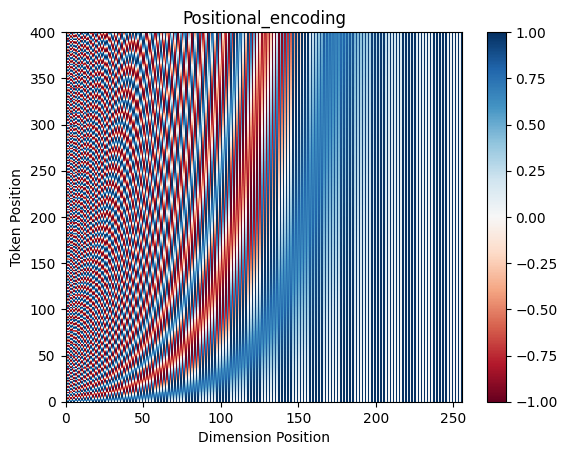

In [12]:
import matplotlib.pyplot as plt

def positional_encoding(position, d_model):
    # [:, None] (max_len,)shape을 (max_len,1)로 만들기 위한 장치입니다.
    # [None, :] (1,embedding)으로 만드는 장치
    # [None, ...] 가장 앞의 축에 1을 부여하는 장치, 후에 batch 차원을 위해 마련한 것것
    angle_rads = get_angles(np.arange(position)[:, None], np.arange(d_model)[None, :], d_model)
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    pos_encoding = angle_rads[None, ...]

    return torch.FloatTensor(pos_encoding)

# 위치 인코딩 시각화
plt.pcolormesh(positional_encoding(example_length, example_dim).numpy()[0,:,:], cmap='RdBu')  # 깊이에 따른 위치 인코딩 시각화
plt.ylabel('Token Position')
plt.xlabel('Dimension Position')
plt.title('Positional_encoding')
plt.colorbar()  # 컬러바 추가
plt.show()

## [MY CODE] Total Model

- positional encoding을 parameter로 넘겨야 하는 이유는 모델의 파라미터로 포함을 시키기 위해서입니다.

- 모델의 파라미터로 포함 시켜야 하는 이유는 optimizer에 모델의 파라미터로서 넘기기 위해서입니다.

- requires_grad를 false로 둔 이유는 학습은 시키지 않기 위해서입니다.

In [13]:
class TextClassifier(nn.Module):
    def __init__(self, vocab_size, d_model, n_layers, dff):
        super().__init__()

        self.vocab_size = vocab_size
        self.d_model = d_model
        self.n_layers = n_layers
        self.dff = dff

        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoding = nn.parameter.Parameter(positional_encoding(position = max_len, d_model = d_model), requires_grad=False)
        self.layers = nn.ModuleList([TransformerLayer(input_dim=d_model, d_model=d_model, dff= dff) for _ in range(self.n_layers)])
        self.classification = nn.Linear(d_model, self.vocab_size)

    def forward(self, x):
        # x의 shape은 batch, max_len, dimension 입니다.
        mask = (x == tokenizer.pad_token_id)
        mask = mask[:, None, :]
        seq_len = x.shape[1]

        x = self.embedding(x)
        x = x * sqrt(self.d_model)
        x = x + self.pos_encoding[:, :seq_len]

        for layer in self.layers:
            x = layer(x, mask)

        x = x[:, 0]
        x = self.classification(x)

        return x
    
model = TextClassifier(
        vocab_size=vocab_size,
        d_model=d_model,
        n_layers=n_layers,
        dff=dff
)
model = model.to(device)

In [14]:
print(model)

TextClassifier(
  (embedding): Embedding(30522, 32)
  (layers): ModuleList(
    (0-1): 2 x TransformerLayer(
      (self_attention): SelfAttention(
        (wq): Linear(in_features=32, out_features=32, bias=True)
        (wk): Linear(in_features=32, out_features=32, bias=True)
        (wv): Linear(in_features=32, out_features=32, bias=True)
        (dense): Linear(in_features=32, out_features=32, bias=True)
        (softmax): Softmax(dim=-1)
      )
      (ffn): Sequential(
        (0): Linear(in_features=32, out_features=32, bias=True)
        (1): ReLU()
        (2): Linear(in_features=32, out_features=32, bias=True)
      )
    )
  )
  (classification): Linear(in_features=32, out_features=30522, bias=True)
)


## [MY CODE] loss, optimizer, learning rate

- 마지막 토큰을 찾는 것은 다중 분류이기 때문에 cross entropy를 사용합니다.

- optimizer는 adam으로 했다.

In [15]:
from torch.optim import Adam

lr = 1e-3
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=lr)

## [MY CODE] Train 

- epoch = 50

- metric: acc와 f1 score

## [LOG] Train and Val log

## [FEEDBACK] 왜 argmax가 아닌가에 대하여

초기 코드에 아래와 같은 수식이 선언되어 있었다.

preds = model(inputs)[...,0]

아마 reduce_sum 같은 의도가 담겨 있는듯 하다.

즉, 모델의 출력 차원을 모두 압축하여 하나의 숫자로 대표한 다음 하나의 라벨값과 비교한다, 라는 의도였던 것 같다. 

그리고 대부분의 텍스트 분류 또는 라벨 비교 태스크에서는 CLS 토큰(문장의 첫 번째 토큰)을 사용하여 문장 수준의 정보를 나타낸다.

그러나 학습이 아예 안 되던 모습이 출력되었다.

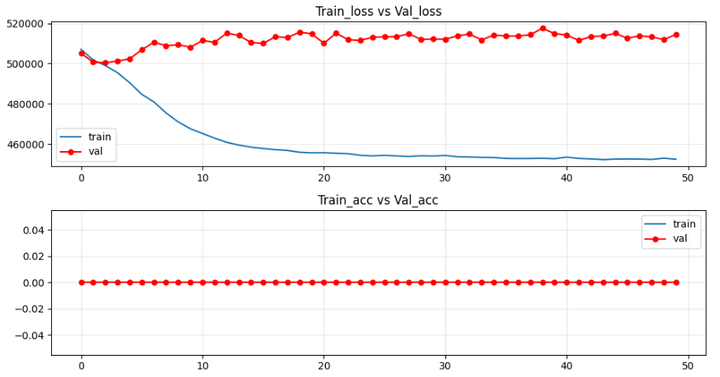


model의 출력 계층을 vocab_size로 바꾸고

preds = model(inputs)으로 한 다음 그대로 loss 함수에 태우면 학습이 되는 모습이 나타났다.

물론 metric을 찍어야 하기 때문에 argmax로 가장 값이 큰 곳의 인덱스와 라벨 값을 비교하여 accuracy와 f1 score을 계산해냈다.

어디가 문제였는지를 고민해보면, 모델 선언 시에 마지막에 classifier를 달아준 것이 문제였다고 생각한다.

마지막에 classifier를 달지 않고서, 0번 토큰만 즉 cls 토큰으로 예측을 했다면 예측이 되었을지도 모를 것 같다. 그러나 나는 classifier를 선언했기에 위와 같은 절차를 진행했어야 했다.

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score

def train(model, train_loader):
  total_loss = 0.
  acc = []
  f1 = []
  model.train()
  for data in train_loader:
    model.zero_grad()
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device).long()

    # 가장 첫번째 토큰을 뽑아내는 것이 아니라, 출력값 전체를 활용
    # (64, 30522) = preds shape => type = float 형태
    # labels.shape: (64,) => type = long 형태
    preds = model(inputs)
    loss = loss_fn(preds, labels)
    loss.backward()
    optimizer.step()

    preds = torch.argmax(preds, dim=-1).long()
    preds = preds.detach().cpu().numpy()
    labels = labels.detach().cpu().numpy()
    acc.append(accuracy_score(preds, labels))
    f1.append(f1_score(preds, labels, average="weighted"))

    total_loss += loss.item()
  total_loss /= len(train_loader)
  return total_loss, {'acc':np.mean(acc), 'f1':np.mean(f1)}

def eval(model, data_loader, return_pred_label = False):
  total_loss = 0.
  acc = []
  f1 = []
  if return_pred_label:
    preds_lst = []
    labels_lst = []
  with torch.no_grad():
    model.eval()
    for data in data_loader:
      inputs, labels = data
      inputs, labels = inputs.to(device), labels.to(device).long()

      preds = model(inputs)
      loss = loss_fn(preds, labels)
      loss.backward()
      optimizer.step()

      preds = torch.argmax(preds, dim=-1).long()
      preds = preds.detach().cpu().numpy()
      labels = labels.detach().cpu().numpy()
      acc.append(accuracy_score(preds, labels))
      f1.append(f1_score(preds, labels, average="weighted"))

      if return_pred_label:
        preds_lst.extend(list(preds))
        labels_lst.extend(list(labels))

      total_loss += loss.item()
    total_loss /= len(data_loader)

  if return_pred_label:
    return total_loss, {'acc':np.mean(acc), 'f1':np.mean(f1)}, {'preds':preds_lst, 'labels': labels_lst}
  else:
    return total_loss, {'acc':np.mean(acc), 'f1':np.mean(f1)}


In [17]:
train_logs = {'loss':[], 'metric':{'acc':[], 'f1':[]}}
val_logs = {'loss':[], 'metric':{'acc':[], 'f1':[]}}
for epoch in range(n_epochs):
  train_loss, train_metric = train(model = model, train_loader=train_loader)
  val_loss, val_metric = eval(model = model, data_loader=val_loader)

  train_logs['loss'].append(train_loss)
  train_logs['metric']['acc'].append(train_metric['acc'])
  train_logs['metric']['f1'].append(train_metric['f1'])
  val_logs['loss'].append(val_loss)
  val_logs['metric']['acc'].append(val_metric['acc'])
  val_logs['metric']['f1'].append(val_metric['f1'])

  print(f"Epoch {epoch+1:3d} | Train Loss: {train_loss:.3f} | Val Loss: {val_loss:.3f} ")
  print(f"=========> Train acc: {train_metric['acc']:.3f} | Train f1: {train_metric['f1']:.3f}")
  print(f"=========> Val acc: {val_metric['acc']:.3f} | Val f1: {val_metric['f1']:.3f}")
  print('\n\n')

torch.Size([64, 30522])
torch.Size([64, 30522])
torch.Size([64, 30522])
torch.Size([64, 30522])
torch.Size([64, 30522])
torch.Size([64, 30522])
torch.Size([64, 30522])
torch.Size([64, 30522])
torch.Size([64, 30522])
torch.Size([64, 30522])
torch.Size([64, 30522])
torch.Size([64, 30522])
torch.Size([64, 30522])
torch.Size([64, 30522])
torch.Size([64, 30522])
torch.Size([64, 30522])
torch.Size([64, 30522])
torch.Size([64, 30522])
torch.Size([64, 30522])
torch.Size([64, 30522])
torch.Size([64, 30522])
torch.Size([64, 30522])
torch.Size([64, 30522])
torch.Size([64, 30522])
torch.Size([64, 30522])
torch.Size([64, 30522])
torch.Size([64, 30522])
torch.Size([64, 30522])
torch.Size([64, 30522])
torch.Size([64, 30522])
torch.Size([64, 30522])
torch.Size([64, 30522])
torch.Size([64, 30522])
torch.Size([64, 30522])
torch.Size([64, 30522])
torch.Size([64, 30522])
torch.Size([64, 30522])
torch.Size([64, 30522])
torch.Size([64, 30522])
torch.Size([64, 30522])
torch.Size([64, 30522])
torch.Size([64, 

KeyboardInterrupt: 

## [MY CODE] Plotting

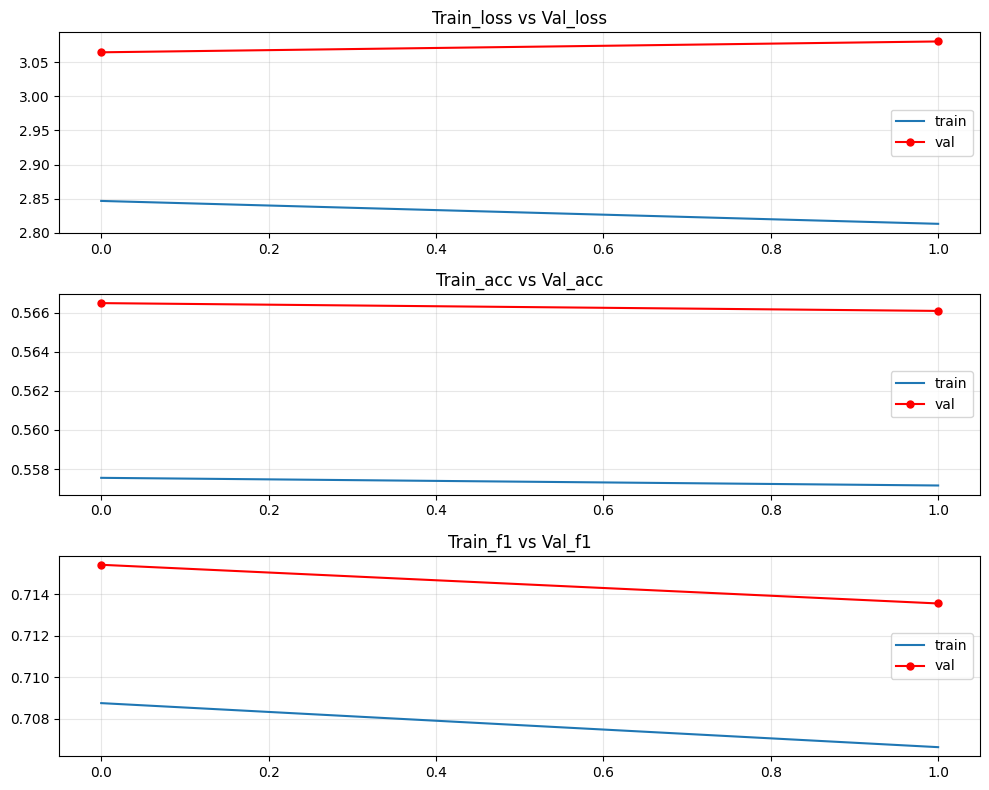

In [92]:
plt.figure(figsize=(10,8))
plt.subplot(3,1,1)
plt.plot(range(len(train_logs['loss'])), train_logs['loss'], label='train')
plt.plot(range(len(val_logs['loss'])), val_logs['loss'], linestyle='-', marker='o', markersize=5, color='red', label='val')
plt.grid(alpha=0.3)
plt.legend()
plt.title("Train_loss vs Val_loss")

plt.subplot(3,1,2)
plt.plot(range(len(train_logs['metric']['acc'])), train_logs['metric']['acc'], label='train')
plt.plot(range(len(val_logs['metric']['acc'])), val_logs['metric']['acc'], linestyle='-', marker='o', markersize=5, color='red', label='val')
plt.grid(alpha=0.3)
plt.legend()
plt.title("Train_acc vs Val_acc")

plt.subplot(3,1,3)
plt.plot(range(len(train_logs['metric']['f1'])), train_logs['metric']['f1'], label='train')
plt.plot(range(len(val_logs['metric']['f1'])), val_logs['metric']['f1'], linestyle='-', marker='o', markersize=5, color='red', label='val')
plt.grid(alpha=0.3)
plt.legend()
plt.title("Train_f1 vs Val_f1")
plt.tight_layout()
plt.show()

## [LOG] Test metric

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

test_loss, test_metric, test_results = eval(model, test_loader, return_pred_label=True)

print(f"Test Loss: {test_loss:.3f}")
print(f"=========> Test acc: {test_metric['acc']:.3f} | Test f1: {test_metric['f1']:.3f}")

Test Loss: 3.120
=========> Test acc: 0.558 | Test f1: 0.707
